In [1]:
map_labels = {

 1: "Normal (NORM)",
 2: "Atrial fibrillation (AF)",
 3: "First-degree atrioventricular block (I-AVB)",
 4: "Left bundle branch block (LBBB)",
 5: "Right bundle branch block (RBBB)",
 6: "Premature atrial contraction (PAC)",
 7: "Premature ventricular contraction (PVC)",
 8: "ST-segment depression (STD)",
 9: "ST-segment elevated (STE)"
}

In [2]:
import torch 
import gc 
import pandas 
import os 

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from EcgStuffs.src.dpnet import dpnet_loader, conf
import torch 

device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    model = dpnet_loader.load() #load auto encoder model
else:
    model =  dpnet_loader.load_cpu()
model.load_state_dict(torch.load("model_ptbxl2.pt"))
model = model.to(device)

/home/ulomoio/Scrivania/ECG_DSS_CAE


In [4]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

In [5]:
def arrange_leads(data):
    col1, col2 = 3, 4

    # Swap columns
    data[:, [col1, col2]] = data[:, [col2, col1]]
    return data

In [6]:
!python --version

Python 3.8.19


In [7]:
torch.__version__

'1.13.1+cu116'

In [8]:
torch.cuda.is_available()

True

In [9]:
%matplotlib inline

In [10]:
%cd "/home/ulomoio/Scrivania/ECG_DSS_CAE/CPSC2018"

/home/ulomoio/Scrivania/ECG_DSS_CAE/CPSC2018


In [11]:
import os
cwd = os.getcwd()
sep = os.sep
cwd

'/home/ulomoio/Scrivania/ECG_DSS_CAE/CPSC2018'

In [12]:
torch.set_float32_matmul_precision("medium")

In [13]:
labels = list(map_labels.values())
labels

['Normal (NORM)',
 'Atrial fibrillation (AF)',
 'First-degree atrioventricular block (I-AVB)',
 'Left bundle branch block (LBBB)',
 'Right bundle branch block (RBBB)',
 'Premature atrial contraction (PAC)',
 'Premature ventricular contraction (PVC)',
 'ST-segment depression (STD)',
 'ST-segment elevated (STE)']

In [14]:
os.getcwd()

'/home/ulomoio/Scrivania/ECG_DSS_CAE/CPSC2018'

In [15]:
sets = {"TrainingSet1": {}, "TrainingSet2": {}, "TrainingSet3": {}}
sets

{'TrainingSet1': {}, 'TrainingSet2': {}, 'TrainingSet3': {}}

In [16]:
import pandas as pd 
labels_csv = pd.read_csv("REFERENCE.csv")
labels_csv

,Recording,First_label,Second_label,Third_label
0,A0001,5,NaN,NaN
1,A0002,1,NaN,NaN
2,A0003,2,NaN,NaN
3,A0004,2,NaN,NaN
4,A0005,7,NaN,NaN
...,...,...,...,...
6872,A6873,3,NaN,NaN
6873,A6874,8,NaN,NaN
6874,A6875,4,NaN,NaN
6875,A6876,2,NaN,NaN


In [17]:
from scipy.signal import butter, lfilter, iirnotch

def bandpass(lowcut, highcut, order=3, fs = 500):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def notch_filter(cutoff, q, fs=500):
    
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def myfilter(lowcut, highcut, powerline, data):
    
    nchs = 12
    filtered_data = np.zeros_like(data)
    for ch in range(nchs):
        ch_data = data[:, ch]
        b, a = bandpass(lowcut, highcut)   
        x = lfilter(b, a, ch_data)
        f, e = notch_filter(powerline, 30)
        z = lfilter(f, e, x) 
        filtered_data[:, ch] = (x)
    return filtered_data

In [18]:
import scipy.io
import numpy as np 

fs_hr = 500
sec = 10
for set in sets.keys():
    print(set)
    filenames = os.listdir(cwd+os.sep+set)
    for i, filename in enumerate(filenames):
        if i+1 in np.arange(1, len(filenames), 100):
            print(i+1)
        signal = scipy.io.loadmat(cwd+os.sep+set+os.sep+filename)
        record = filename.split(".")[0]
        label = labels_csv[labels_csv["Recording"] == record].values[0]
        signal = signal["ECG"][0][0][-1]
        signal = torch.from_numpy(signal)
        signal = myfilter(0.5, 100, 50, signal.T)
        signal = torch.from_numpy(signal.T)
        zeros = torch.zeros((3, signal.shape[-1]))
        signal = torch.cat([signal, zeros], dim = 0)
        sets[set][record] = {"data": signal, "label": label}
    print()
sets

TrainingSet1
1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901

TrainingSet2
1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401

TrainingSet3
1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501


ValueError: Unknown mat file type, version 10, 65

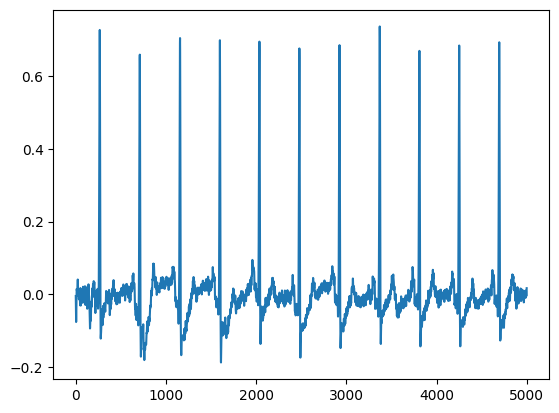

In [19]:
import matplotlib.pyplot as plt 
plt.plot(signal[0, :].cpu().detach().numpy())

In [20]:
from sklearn.metrics import roc_curve, auc 

def plot_roc_curve(y, y_pred):
    # calculate the fpr, tpr, AUC and plot the ROC curve 
    '''
    input: 
    y: array-like contenente i valori dell'attributo target
    y_pred: array-like contenente le predizioni dell'attributo target
    output: None
    
    '''
    y = np.array(y)       #cast array-like in numpy array
    y_pred = np.array(y_pred)
    labels = np.unique(y)
    fpr, tpr, threshold = roc_curve(y, y_pred)
    #print(fpr, tpr)
    roc_auc = round(auc(fpr, tpr), 4)
    
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC {}'.format(roc_auc))
    plt.legend(loc = 'lower right')
    plt.plot(labels, labels,'r--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [21]:
def plot_cm(cm):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    sns.set(style='white')
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(np.eye(2), annot=cm, fmt='g', annot_kws={'size': 50},
                cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
                yticklabels=['Normal', 'Abnormal'], xticklabels=['Normal', 'Abnormal'], ax=ax)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=20, length=0)

    ax.set_title('Seaborn Confusion Matrix with labels', size=24, pad=20)
    ax.set_xlabel('Predicted Values', size=20)
    ax.set_ylabel('Actual Values', size=20)

    additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
    for text_elt, additional_text in zip(ax.texts, additional_texts):
        ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
                ha='center', va='top', size=24)
    plt.tight_layout()
    plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

def validate_model(y_trues, y_preds):

    TP = 0
    FP = 0
    TN = 0
    FN = 0
    idxs_missclassified = []

    for i, y_true in enumerate(y_trues):

        y_pred = y_preds[i]

        if y_true == 1: #"N":
            if y_pred == y_true:
                TN += 1
            else:
                FP += 1
                idxs_missclassified.append(i)

        else:
            if y_pred == y_true:
                TP += 1 
            else:
                FN += 1
            idxs_missclassified.append(i)
    
    TP, FN, FP, TN = confusion_matrix(y_trues, y_preds).ravel() 
            
    acc = (TP+TN)/(TP+TN+FP+FN)
    if FN + TP != 0:
        TPR = TP/(FN+TP) #sensitivity 
        FNR = FN/(FN+TP)
        recall = TPR
    else: 
        TPR = None
        FNR = None 
        recall = None
    
    if TN+FP != 0:
        
        TNR = TN/(TN+FP) #specificity
        FPR = FP/(TN+FP)
    else: 
        TNR = None
        FPR = None 
    
    if TP+FP != 0:
        precision = TP/(TP+FP)
    else:
        precision = None
    
    if precision != 0 and recall != 0:
        f1 = (2*precision*recall)/(precision+recall)
    else:
        f1 = None 
    
    cr = classification_report(y_trues, y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    auc = roc_auc_score(y_trues, y_preds)
    metrics = {
        "accuracy": acc,
        "f1": f1,
        "cm": cm,
        "sensitivity": TPR,
        "specificity": TNR,
        "missed allarm rate": FPR,
        "false allarm rate": FNR,
        "auc_score": auc,
        "precision": precision,
        "recall": recall,
        "report": cr,
        "predictions": y_preds,
        "idxs_missclassified": idxs_missclassified
    }
    plot_roc_curve(y_trues, y_preds)
    plot_cm(cm)
    return metrics, "Accuracy: {} \n F1 score: {} \n Sensitivity: {} \n Specificity: {} \n ROC AUC score: {} \n False Allarm Rate: {}, Missed Allarm Rate: {} \n Confusion Matrix: \n {} \n Classification Report: \n {} \n".format(acc, f1, TPR, TNR, auc, FNR, FPR, cm, cr)

In [23]:
from IPython.display import clear_output

In [24]:
#!pip install dill==0.3.6

In [25]:
import torch
torch.__version__

'1.13.1+cu116'

In [26]:
torch.cuda.is_available()

True

In [27]:
model.eval()

DPNet(
  (encoder): Encoder(
    (conv_0): Conv2d(1, 15, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (activation0): Tanh()
    (conv_1): Conv2d(15, 30, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (activation1): Tanh()
    (block_0): EncoderBlock(
      (conv2d_in): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (activation_in): Tanh()
      (batch_norm_in): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_in): Dropout(p=0.2, inplace=False)
      (conv2d_out): Conv2d(30, 45, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (skip_con): Sequential(
        (0): Conv2d(30, 45, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (batch_norm_out): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_o

In [28]:
gc.collect()
torch.cuda.empty_cache()

In [29]:
channels = ["i", "ii", "iii", "aVR", "aVL", "aVF", "v1", "v2" ,"v3", "v4", "v5", "v6", "x", "y", "z"]

In [30]:
map_y_final = {0: "Normal", 1: "Anomalous"}

In [31]:
labels = list(map_labels.values())
labels

['Normal (NORM)',
 'Atrial fibrillation (AF)',
 'First-degree atrioventricular block (I-AVB)',
 'Left bundle branch block (LBBB)',
 'Right bundle branch block (RBBB)',
 'Premature atrial contraction (PAC)',
 'Premature ventricular contraction (PVC)',
 'ST-segment depression (STD)',
 'ST-segment elevated (STE)']

In [32]:
all_signals = []
all_y = []
for set, datas in sets.items():
    print(set)
    for patient, data in datas.items():
        signal = data["data"]
        signal = torch.tensor(signal).float()
        label = data["label"]
        label = label[1]
        all_signals.append(signal)
        all_y.append(label)

len(all_y), len(all_signals)

TrainingSet1


/tmp/ipykernel_6244/1069484715.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal = torch.tensor(signal).float()


TrainingSet2
TrainingSet3


(6006, 6006)

In [33]:
map_y_final

{0: 'Normal', 1: 'Anomalous'}

In [34]:
map_labels

{1: 'Normal (NORM)',
 2: 'Atrial fibrillation (AF)',
 3: 'First-degree atrioventricular block (I-AVB)',
 4: 'Left bundle branch block (LBBB)',
 5: 'Right bundle branch block (RBBB)',
 6: 'Premature atrial contraction (PAC)',
 7: 'Premature ventricular contraction (PVC)',
 8: 'ST-segment depression (STD)',
 9: 'ST-segment elevated (STE)'}

In [35]:
np.unique(all_y)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
all_y

[5,
 5,
 8,
 2,
 8,
 5,
 6,
 3,
 2,
 9,
 5,
 3,
 5,
 7,
 3,
 1,
 1,
 5,
 4,
 4,
 2,
 2,
 1,
 8,
 4,
 5,
 5,
 2,
 5,
 2,
 2,
 8,
 1,
 5,
 8,
 3,
 8,
 4,
 3,
 1,
 1,
 1,
 5,
 6,
 5,
 5,
 3,
 5,
 3,
 3,
 6,
 3,
 6,
 6,
 2,
 2,
 3,
 1,
 5,
 2,
 8,
 5,
 8,
 5,
 2,
 1,
 2,
 1,
 8,
 3,
 1,
 7,
 3,
 3,
 1,
 1,
 2,
 4,
 8,
 5,
 1,
 3,
 3,
 8,
 5,
 2,
 6,
 7,
 5,
 8,
 6,
 5,
 1,
 1,
 5,
 1,
 8,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 6,
 1,
 5,
 1,
 2,
 7,
 4,
 3,
 6,
 7,
 1,
 3,
 5,
 1,
 5,
 1,
 7,
 2,
 7,
 8,
 3,
 8,
 1,
 3,
 2,
 1,
 1,
 8,
 6,
 5,
 2,
 3,
 9,
 1,
 2,
 7,
 3,
 8,
 2,
 7,
 2,
 2,
 8,
 7,
 4,
 5,
 7,
 2,
 3,
 5,
 7,
 3,
 5,
 5,
 6,
 8,
 5,
 1,
 3,
 2,
 5,
 8,
 1,
 3,
 9,
 3,
 4,
 5,
 5,
 2,
 2,
 8,
 7,
 8,
 1,
 3,
 5,
 1,
 2,
 5,
 6,
 8,
 2,
 7,
 3,
 1,
 5,
 6,
 7,
 1,
 1,
 2,
 4,
 3,
 8,
 8,
 5,
 1,
 2,
 1,
 8,
 4,
 5,
 7,
 7,
 5,
 7,
 5,
 3,
 5,
 5,
 2,
 2,
 2,
 5,
 2,
 2,
 9,
 5,
 7,
 6,
 5,
 1,
 5,
 3,
 5,
 9,
 3,
 7,
 2,
 8,
 8,
 5,
 4,
 1,
 6,
 1,
 7,
 5,
 7,
 7,
 2,
 8,
 2,
 7,
 1,


In [37]:
import math 

def sliding_window(signal, size=500, stride=500):
    
    windows = []
    #print(signal.shape)
    sig_len = signal.shape[-1]
    win_num = math.ceil((sig_len - size) / stride) + 1
    for i in range(win_num):
        offset = i * stride
        #print(offset, offset + size)
        windows.append((signal[:, offset : offset + size]))
    return windows

In [51]:
map_labels_rev = {value: key for key, value in map_labels.items()}
map_labels_rev

{'Normal (NORM)': 1,
 'Atrial fibrillation (AF)': 2,
 'First-degree atrioventricular block (I-AVB)': 3,
 'Left bundle branch block (LBBB)': 4,
 'Right bundle branch block (RBBB)': 5,
 'Premature atrial contraction (PAC)': 6,
 'Premature ventricular contraction (PVC)': 7,
 'ST-segment depression (STD)': 8,
 'ST-segment elevated (STE)': 9}

In [52]:
from torch.functional import F 
import numpy as np 

fs = 500 
nchs = 15 
interval2 = fs*3
interval = fs*4
reconstruction_errors = []
n = len(all_signals)
rec_error_label = {label: [] for label in labels}

xtest = []
ytest = []
ytestbin = []

for i, signal in enumerate(all_signals): 
    
    signal = signal.to(device)
    windows = sliding_window(signal, size = interval, stride = interval2)
    label = all_y[i]
    label = map_labels[label]
    #print(len(windows))
    for window in windows:

        if window.shape[-1] == 2000:

            reconstruction_all = np.zeros((nchs, interval2))        
            window = torch.unsqueeze(window, dim = 0).to(device)
            window = torch.unsqueeze(window, dim = 0).to(device)
            with torch.no_grad():
                
                reconstruction = model(window)
                reconstruction_error = F.mse_loss(reconstruction[0, 0, :, :interval2], window[0, 0, :, :interval2]).item()
                if i+1 in np.arange(1, n, 100):
                    print(i+1, "/", n, "Recon error:", round(reconstruction_error, 6), "Label:", label, end = "\r")
                    torch.cuda.empty_cache()
                    gc.collect()
                reconstruction_errors.append(reconstruction_error)
        
                rec_error_label[label].append(reconstruction_error)
                recon_np = (reconstruction[0, 0, :, :interval2].cpu().detach().numpy()).reshape(1, nchs, interval2)
                reconstruction_all[:, :] = recon_np[0, :, :interval2]
        
            xtest.append(window)
            label_bin = 0 if label == "Normal (NORM)" else 1
            ytest.append(map_labels_rev[label])
            ytestbin.append(label_bin)
            del window
            del reconstruction 
            del reconstruction_error
            del recon_np
    del windows
    del signal
        

In [53]:
np.unique(label_bin)

array([1])

In [54]:
rec_error_label.keys()

dict_keys(['Normal (NORM)', 'Atrial fibrillation (AF)', 'First-degree atrioventricular block (I-AVB)', 'Left bundle branch block (LBBB)', 'Right bundle branch block (RBBB)', 'Premature atrial contraction (PAC)', 'Premature ventricular contraction (PVC)', 'ST-segment depression (STD)', 'ST-segment elevated (STE)'])

In [55]:
rec_error_label['Normal (NORM)']

[0.005620994139462709,
 0.00324275647290051,
 0.0028501381166279316,
 0.0023036187049001455,
 0.0028531101997941732,
 0.005806992761790752,
 0.009137970395386219,
 0.008360837586224079,
 0.006193540059030056,
 0.0057630580849945545,
 0.005764390807598829,
 0.005693541374057531,
 0.006626947782933712,
 0.005627709906548262,
 0.02334875799715519,
 0.020405834540724754,
 0.024145329371094704,
 0.024646146222949028,
 0.023381363600492477,
 0.06627796590328217,
 0.03874363750219345,
 0.026173068210482597,
 0.008144453167915344,
 0.008178288117051125,
 0.008198103867471218,
 0.00745775643736124,
 0.006957800593227148,
 0.008035470731556416,
 0.009116037748754025,
 0.007976703345775604,
 0.007245212327688932,
 0.005248765926808119,
 0.004528560675680637,
 0.0055444566532969475,
 0.00493650184944272,
 0.005805428605526686,
 0.004017342813313007,
 0.004993075970560312,
 0.004794561304152012,
 0.015543772839009762,
 0.01023122575134039,
 0.013066387735307217,
 0.009704429656267166,
 0.0167751573

In [56]:
import pandas as pd 
df = pd.DataFrame([], columns = ["Label", "Min MSE", "Max MSE", "Mean MSE (+/- STD"])
for i, (label, errors) in enumerate(rec_error_label.items()):
    min_ = min(errors)
    max_ = max(errors)
    mean = round(np.mean(errors), 4)
    std = round(np.std(errors), 4)
    df.loc[i] = [label, min_, max_, f"{mean}+-{std}"]
df.set_index("Label")

,Min MSE,Max MSE,Mean MSE (+/- STD
Label,,,
Normal (NORM),0.001624,4.160019,0.0156+-0.1048
Atrial fibrillation (AF),0.002911,5.932667,0.0733+-0.3091
First-degree atrioventricular block (I-AVB),0.002129,5.624993,0.0253+-0.1473
Left bundle branch block (LBBB),0.007114,9.172614,0.2528+-0.8165
Right bundle branch block (RBBB),0.002102,27.765331,0.1064+-0.8492
Premature atrial contraction (PAC),0.001961,4.490967,0.035+-0.1888
Premature ventricular contraction (PVC),0.001545,20.440142,0.1708+-0.9766
ST-segment depression (STD),0.001856,11.882732,0.0726+-0.5367
ST-segment elevated (STE),0.003068,0.697109,0.0276+-0.0518


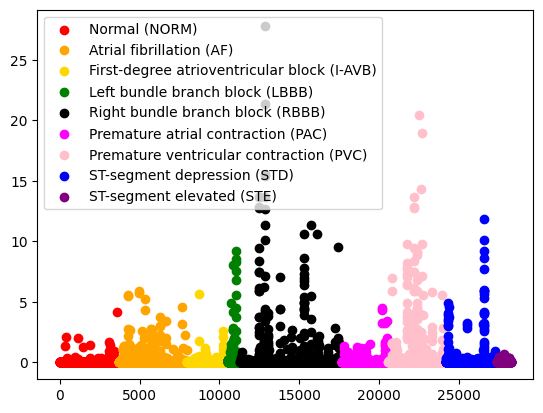

In [57]:
import matplotlib.pyplot as plt 
j = 0
colors = ["red", "orange", "gold", "green", "black", "magenta", "pink", "blue", "purple"]
for i, (label, errors) in enumerate(rec_error_label.items()):
    n = len(errors)
    plt.scatter(np.arange(j, (j+n), 1), errors, color = colors[i], label = label)
    j = j+n

plt.legend()

In [58]:

len(reconstruction_errors)

28277

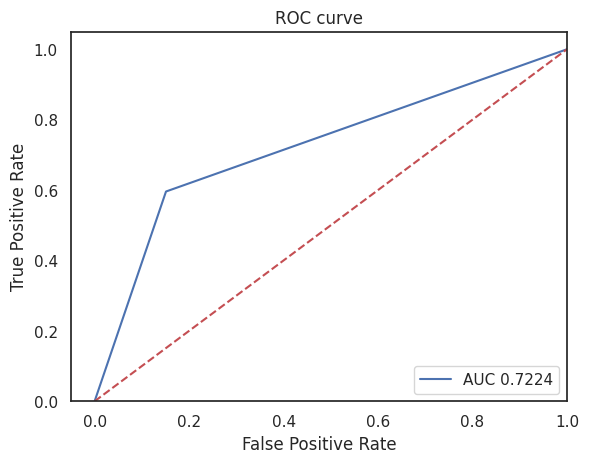

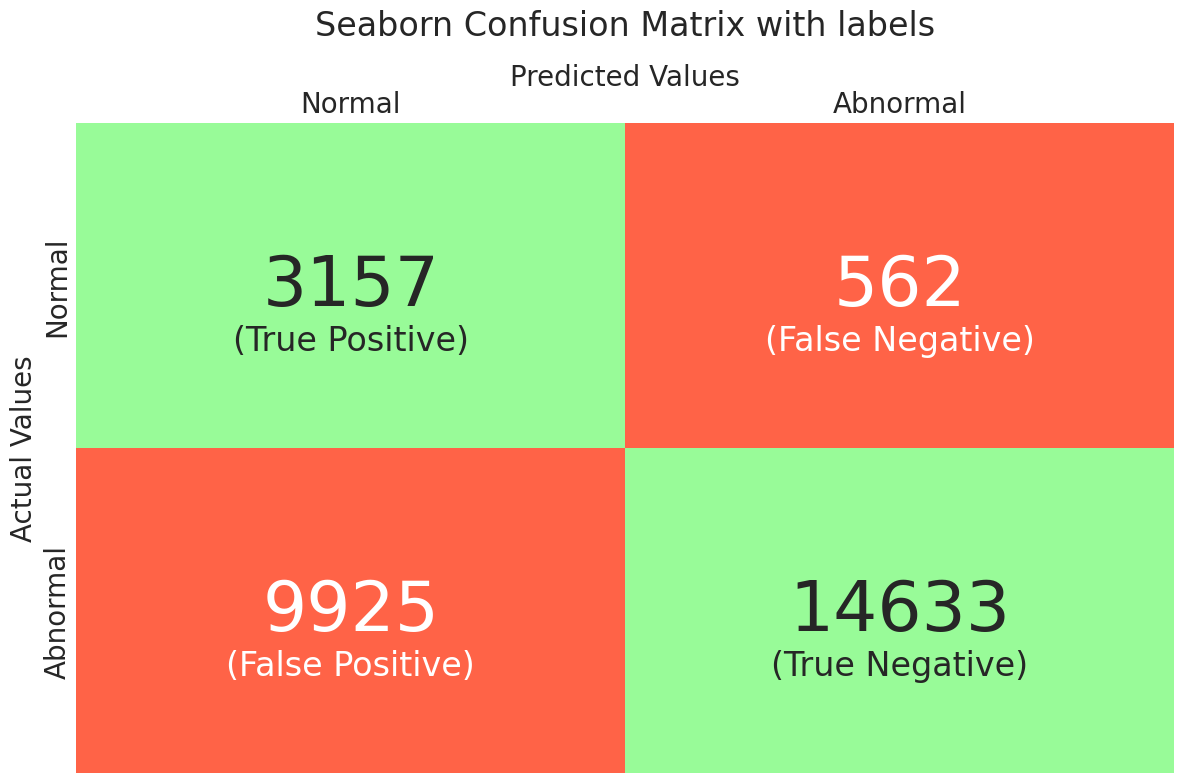

In [66]:
from time import sleep
best_th = 0.0
best_auc = 0.0
normal_mse = []
anomalous_mse = []
count_decr = 0 
fprs = [0]
tprs = [0]
thresholds = np.arange(0.01, 0.02, 0.0002) #np.arange(0.01, 0.5, 0.005)
for j, threshold in enumerate(thresholds):
    print(threshold)
    y_preds = []
    for i, recon_error in enumerate(reconstruction_errors):

        if j == 0:
            if ytestbin[i] == 0:
                normal_mse.append(recon_error)
            else:
                anomalous_mse.append(recon_error)

        if recon_error > threshold:
            y_preds.append(1)
        else:
            y_preds.append(0)
                
        y = ytestbin[i]
        
    sleep(0.5)
    clear_output(wait = True)
    metrics, to_print = validate_model(ytestbin, y_preds)
    auc_score = metrics["auc_score"]
    if auc_score > best_auc:
        best_th = threshold
        best_auc = auc_score
    if auc_score < best_auc:
        count_decr += 1
    if count_decr >= 10: 
        break
    fpr, tpr, _ = roc_curve(ytestbin, y_preds)
    fprs.append(fpr[1])
    tprs.append(tpr[1])
    print(to_print)
fprs.append(1)
tprs.append(1)

Text(-0.039, 3333, 'TP')

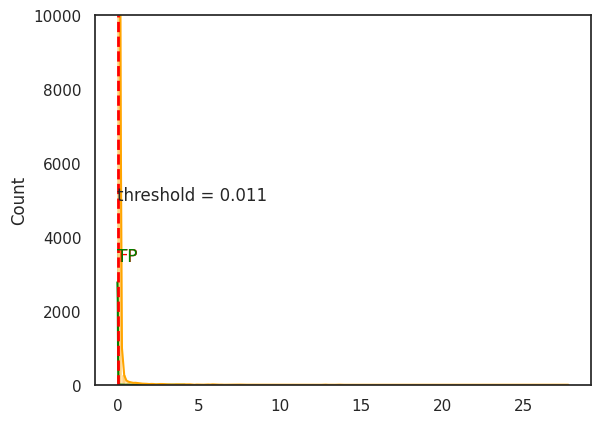

In [67]:
import seaborn as sns 

ymax = 10000
sns.histplot(normal_mse, kde=True, 
             bins=100, color = 'green')
sns.histplot(anomalous_mse, kde=True, 
             bins=100, color = 'orange')
plt.vlines(x = best_th, ymin = 0, ymax = ymax, color = "red", linewidth = 2, linestyles = "dashed")
plt.ylim([0, ymax])
plt.text(x = best_th - 0.05, y = int(ymax/2), s = "threshold = {}".format(round(best_th, 6)))
plt.text(x = best_th + 0.05, y = int(ymax/3), s = "FP", color = "red")
plt.text(x = best_th - 0.05, y =  int(ymax/3), s = "TP", color = "green")

In [68]:
best_th, best_auc

(0.011000000000000003, 0.7285556035931728)

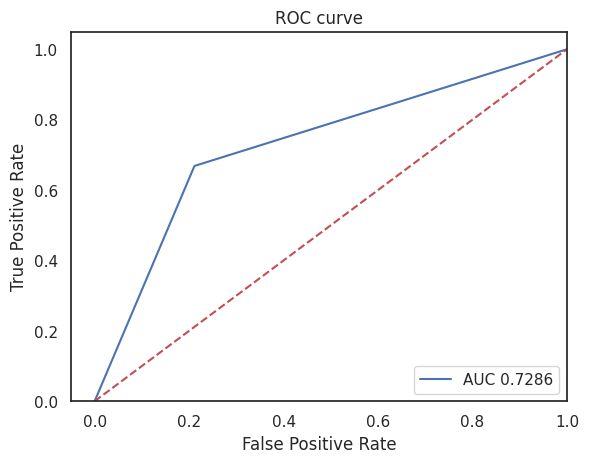

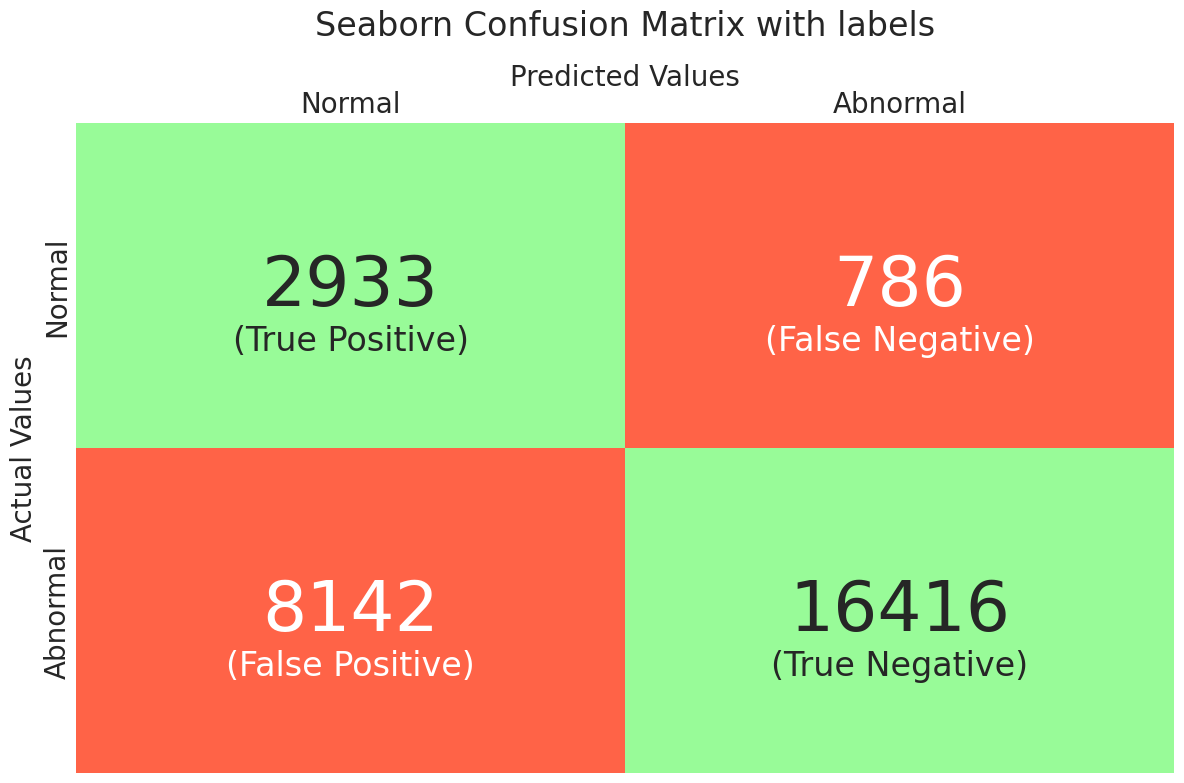

Accuracy: 0.6842663648901934 
 F1 score: 0.3965120994997972 
 Sensitivity: 0.7886528636730303 
 Specificity: 0.6684583435133155 
 ROC AUC score: 0.7285556035931728 
 False Allarm Rate: 0.2113471363269696, Missed Allarm Rate: 0.3315416564866846 
 Confusion Matrix: 
 [[ 2933   786]
 [ 8142 16416]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.26      0.79      0.40      3719
           1       0.95      0.67      0.79     24558

    accuracy                           0.68     28277
   macro avg       0.61      0.73      0.59     28277
weighted avg       0.86      0.68      0.73     28277
 



In [71]:
#best_th = 0.026

windows_labels_preds = []
for i, recon_error in enumerate(reconstruction_errors):
    
    if recon_error > best_th:
        windows_labels_preds.append(1)
    else:
        windows_labels_preds.append(0)
                
    y = ytestbin[i]
        
metrics, to_print = validate_model(ytestbin, windows_labels_preds)
auc_score = metrics["auc_score"]
print(to_print)

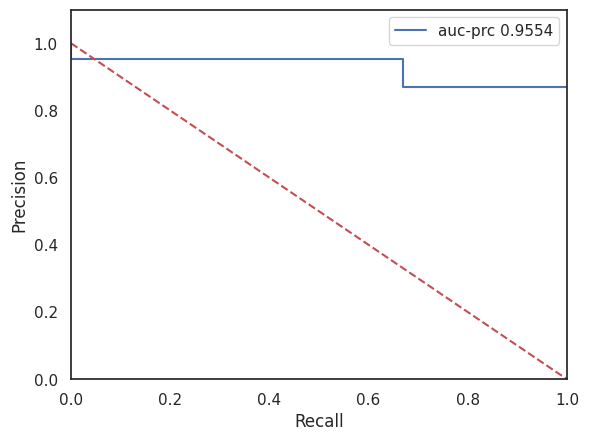

In [72]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

prec, recall, _ = precision_recall_curve(ytestbin,  windows_labels_preds)
auc_pr = auc(recall, prec)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(label="auc-prc {}".format(round(auc_pr, 4)))
plt.plot([0, 1], [1, 0], "--r")
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.legend()

In [73]:
map_labels_rev = {value: key for key, value in map_labels.items()} 
map_labels_rev

{'Normal (NORM)': 1,
 'Atrial fibrillation (AF)': 2,
 'First-degree atrioventricular block (I-AVB)': 3,
 'Left bundle branch block (LBBB)': 4,
 'Right bundle branch block (RBBB)': 5,
 'Premature atrial contraction (PAC)': 6,
 'Premature ventricular contraction (PVC)': 7,
 'ST-segment depression (STD)': 8,
 'ST-segment elevated (STE)': 9}

In [76]:
ytest = torch.tensor(ytest)
xtest = torch.cat(xtest)

In [77]:
idxs_normal = torch.argwhere(ytest == 1)
idxs_normal

tensor([[   80],
        [   81],
        [   82],
        ...,
        [28233],
        [28234],
        [28235]])

In [78]:
X_test_norm = xtest[idxs_normal]
X_test_norm = torch.squeeze(X_test_norm, dim = 1)
X_test_norm.shape

torch.Size([3719, 1, 15, 2000])

In [79]:
idxs_abnormal = torch.argwhere(ytest == 2)
idxs_abnormal

tensor([[   30],
        [   31],
        [   32],
        ...,
        [28253],
        [28254],
        [28255]])

In [80]:
X_test_afib = xtest[idxs_abnormal]
X_test_afib = torch.squeeze(X_test_afib, dim = 1)
X_test_afib.shape

torch.Size([4267, 1, 15, 2000])

In [81]:
X_test_2 = torch.cat([X_test_norm, X_test_afib], dim = 0)
X_test_2.shape

torch.Size([7986, 1, 15, 2000])

In [82]:
y_test_2 = [0 for idx in idxs_normal]
[y_test_2.append(1) for elem in X_test_afib]
y_test_2 = torch.tensor(y_test_2)
y_test_2

tensor([0, 0, 0,  ..., 1, 1, 1])

In [83]:
y_test_2.shape

torch.Size([7986])

In [84]:
map_y_final_2 = {0: "Normal", 1: "AFIB"}
labels = list(map_y_final_2.values())
labels

['Normal', 'AFIB']

In [85]:
from torch.functional import F 
import numpy as np 

fs = 500 
nchs = 15 
interval2 = fs*3
interval = fs*4
reconstruction_errors = []
n = X_test_2.shape[0]
rec_error_label = {label: [] for label in labels}
                   
for i, batch_data in enumerate(X_test_2): 
    
    batch_data = batch_data.to(device)
    #print(batch_data.shape)
    batch_data = torch.unsqueeze(batch_data, dim = 0).to(device)
    label = map_y_final_2[y_test_2[i].item()]
    #print(batch_data.shape)
    reconstruction_all = np.zeros((nchs, interval2))        

    with torch.no_grad():

        reconstruction = model(batch_data)
        reconstruction_error = F.mse_loss(reconstruction[0, 0, :, :interval2], batch_data[0, 0, :, :interval2]).item()
        if i+1 in np.arange(1, n, 1000):
            
            print(i+1, "/", n, "Recon error:", round(reconstruction_error, 6), "Label:", label, end = "\r")
            torch.cuda.empty_cache()
            gc.collect()
        reconstruction_errors.append(reconstruction_error)

        rec_error_label[label].append(reconstruction_error)
        recon_np = (reconstruction[0, 0, :, :interval2].cpu().detach().numpy()).reshape(1, nchs, interval2)
        reconstruction_all[:, :] = recon_np[0, :, :interval2]


    del batch_data
    del reconstruction 
    del reconstruction_error
    del recon_np
    

In [86]:
y_test_2

tensor([0, 0, 0,  ..., 1, 1, 1])

In [87]:
import pandas as pd 
df = pd.DataFrame([], columns = ["Label", "Min MSE", "Max MSE", "Mean MSE (+/- STD"])
for i, (label, errors) in enumerate(rec_error_label.items()):
    min_ = min(errors)
    max_ = max(errors)
    mean = round(np.mean(errors), 4)
    std = round(np.std(errors), 4)
    df.loc[i] = [label, min_, max_, f"{mean}+-{std}"]
df.set_index("Label")

,Min MSE,Max MSE,Mean MSE (+/- STD
Label,,,
Normal,0.001624,4.160019,0.0156+-0.1048
AFIB,0.002911,5.932667,0.0733+-0.3091


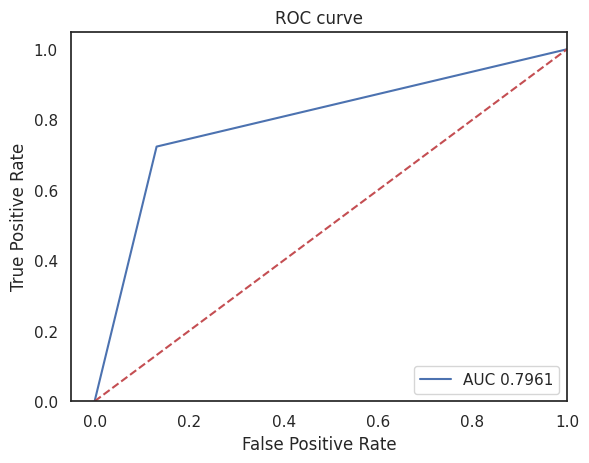

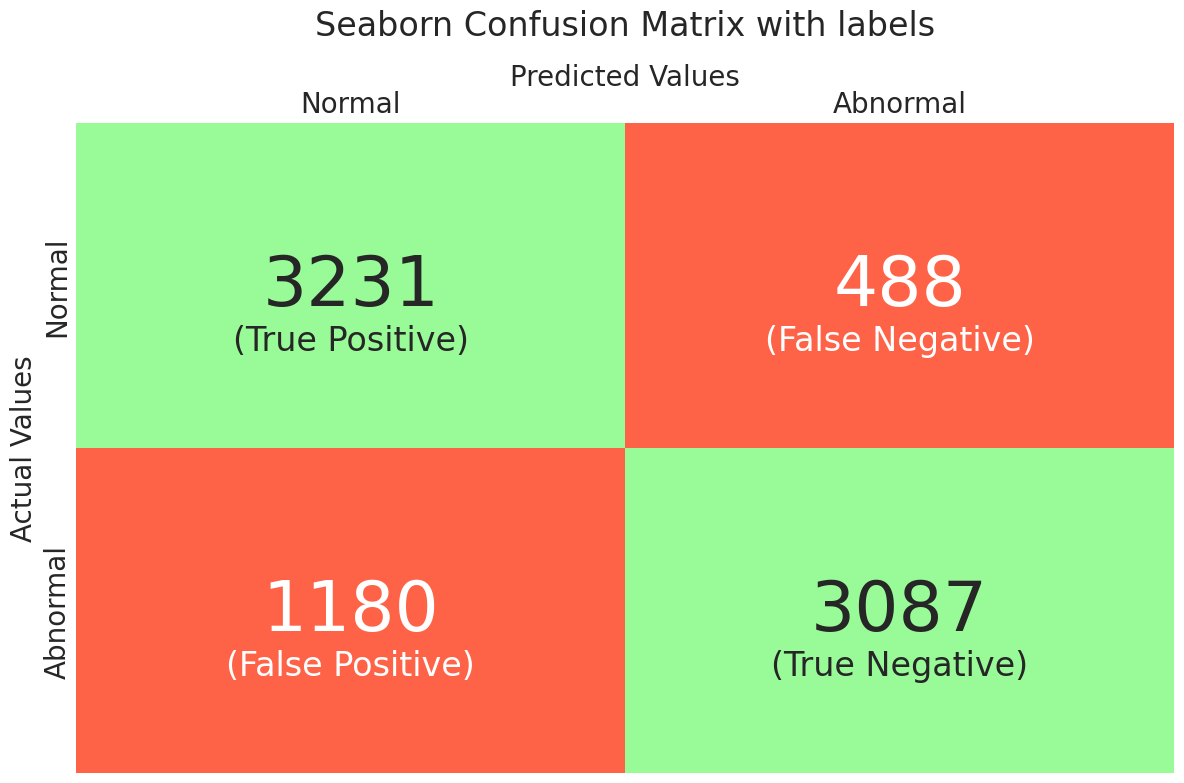

In [89]:
from time import sleep
import matplotlib.pyplot as plt 

best_th = 0.0
best_auc = 0.0
normal_mse = []
anomalous_mse = []
count_decr = 0 
fprs = [0]
tprs = [0]
thresholds = np.arange(0.005, 0.05, 0.0002) #np.arange(0.01, 0.5, 0.005)
for j, threshold in enumerate(thresholds):
    print(threshold)
    y_preds = []
    for i, recon_error in enumerate(reconstruction_errors):

        if j == 0:
            if y_test_2[i] == 0:
                normal_mse.append(recon_error)
            else:
                anomalous_mse.append(recon_error)

        if recon_error > threshold:
            y_preds.append(1)
        else:
            y_preds.append(0)
                
        y = y_test_2[i]
        
    sleep(0.5)
    clear_output(wait = True)
    metrics, to_print = validate_model(y_test_2, y_preds)
    auc_score = metrics["auc_score"]
    if auc_score > best_auc:
        best_th = threshold
        best_auc = auc_score
    if auc_score < best_auc:
        count_decr += 1
    if count_decr >= 10: 
        break
    fpr, tpr, _ = roc_curve(y_test_2, y_preds)
    fprs.append(fpr[1])
    tprs.append(tpr[1])
    print(to_print)
fprs.append(1)
tprs.append(1)

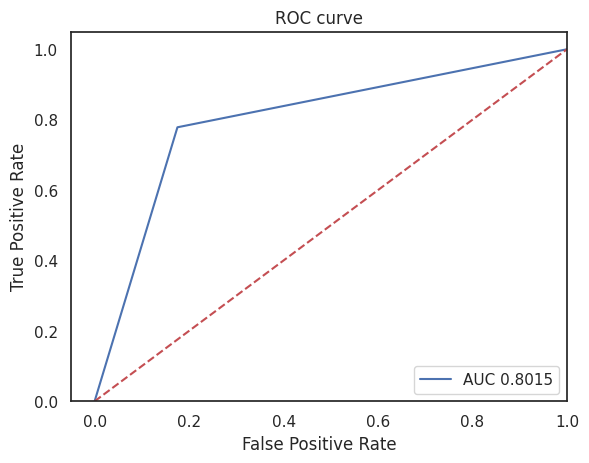

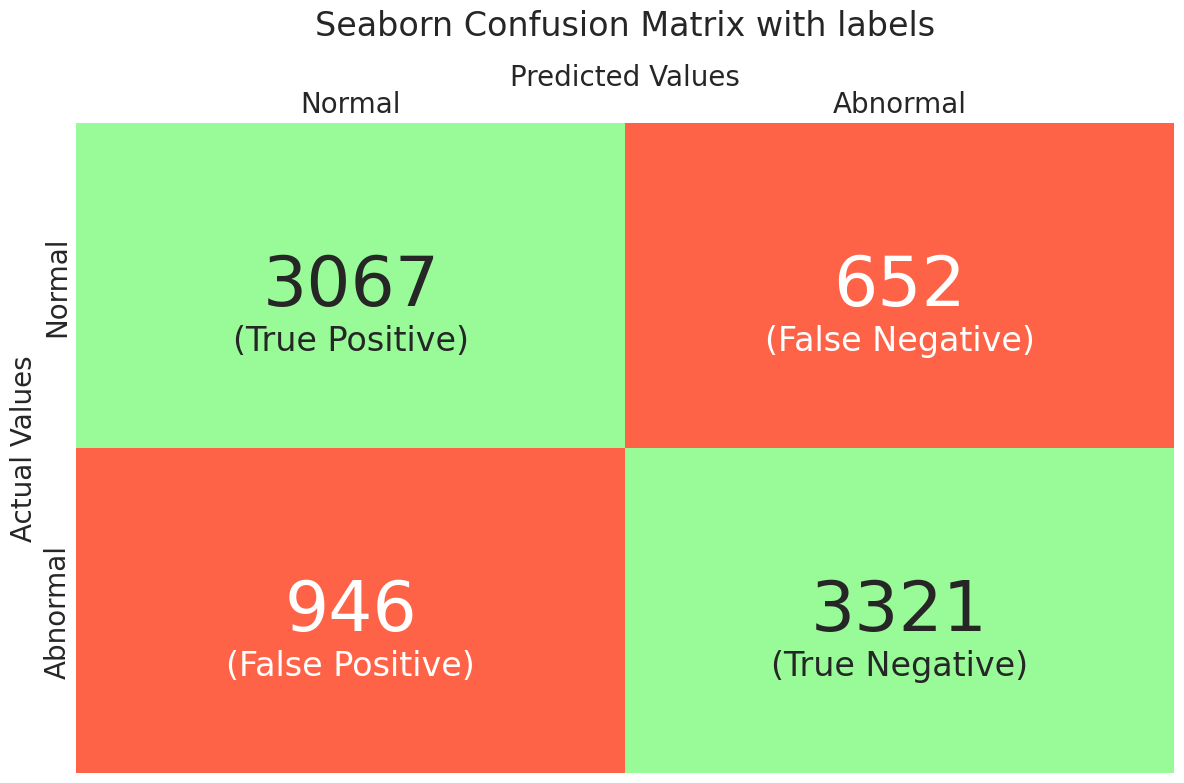

Accuracy: 0.7998998246932131 
 F1 score: 0.7933264355923434 
 Sensitivity: 0.8246840548534552 
 Specificity: 0.7782985704241856 
 ROC AUC score: 0.8014913126388203 
 False Allarm Rate: 0.17531594514654478, Missed Allarm Rate: 0.2217014295758144 
 Confusion Matrix: 
 [[3067  652]
 [ 946 3321]] 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.82      0.79      3719
           1       0.84      0.78      0.81      4267

    accuracy                           0.80      7986
   macro avg       0.80      0.80      0.80      7986
weighted avg       0.80      0.80      0.80      7986
 



In [90]:
#best_th = 0.026

windows_labels_preds = []
for i, recon_error in enumerate(reconstruction_errors):
    
    if recon_error > best_th:
        windows_labels_preds.append(1)
    else:
        windows_labels_preds.append(0)
                
    y = y_test_2[i]
        
metrics, to_print = validate_model(y_test_2, windows_labels_preds)
auc_score = metrics["auc_score"]
print(to_print)

In [91]:
best_th

0.011999999999999988

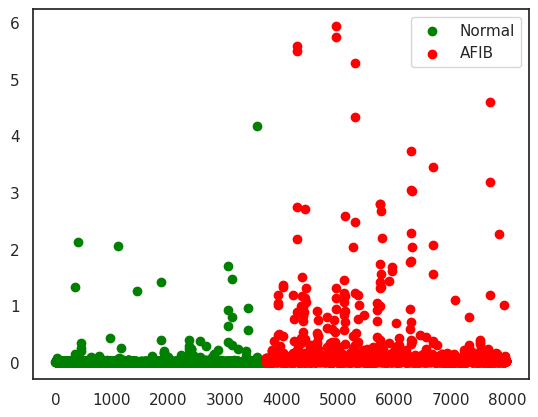

In [92]:
import matplotlib.pyplot as plt 
j = 0
colors = ["green", "red"] #["red", "orange", "gold", "green", "black"]
for i, (label, errors) in enumerate(rec_error_label.items()):
    n = len(errors)
    plt.scatter(np.arange(j, (j+n), 1), errors, color = colors[i], label = label)
    j = j+n
    #plt.ylim([0, 0.1])
plt.legend()